C:\Users\Eier\AppData\Local\Temp\ipykernel_29508\3813891618.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\AppData\Local\Temp\ipykernel_

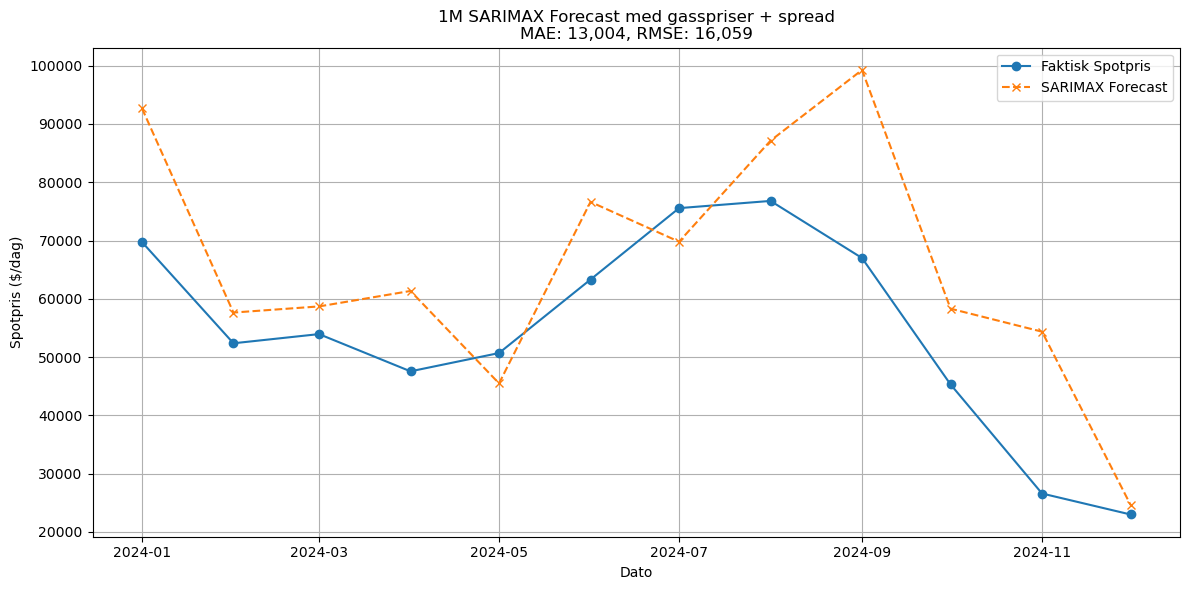

,MAE,RMSE
Month,,
January,22939.91,22939.91
February,5270.27,5270.27
March,4749.17,4749.17
April,13788.71,13788.71
May,5207.64,5207.64
June,13320.26,13320.26
July,5763.11,5763.11
August,10336.08,10336.08
September,32268.04,32268.04


In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# === 1. Load and clean data ===
df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
df.set_index("Date", inplace=True)

# Clean column names
df.columns = df.columns.str.replace('\n', ' ', regex=True).str.strip()

# Rename key columns for easier reference
df = df.rename(columns={
    'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 'Spot_Rate',
    'Global price of Natural Gas, Asia (start month, MMBTU)': 'JKM',
    'Global price of Natural Gas, EU (start month, MMBTU)': 'TTF',
    'Global price of Natural Gas, US Henry Hub (start month, MMBTU)': 'NBP'
})

# === 2. Set up forecast config ===
target = "Spot_Rate"
exog_vars = ["JKM", "TTF", "NBP", "Spread EU-US", "Spread ASIA-US", "Spread ASIA-EU"]
order = (1, 1, 2)
seasonal_order = (1, 0, 0, 12)
forecast_dates = pd.date_range(start="2024-01-01", end="2024-12-01", freq="MS")

forecasts = []
actuals = []
month_labels = []

# === 3. Rolling 1M SARIMAX forecast with log-transform ===
for forecast_date in forecast_dates:
    train_end = forecast_date - pd.DateOffset(months=1)
    train_df = df[:train_end]
    test_df = df.loc[forecast_date:forecast_date]

    if test_df.empty or train_df[exog_vars].isnull().any().any():
        continue

    log_train_target = np.log(train_df[target].dropna())
    exog_train = train_df.loc[log_train_target.index, exog_vars]
    exog_test = test_df[exog_vars]

    model = SARIMAX(
        log_train_target,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log = model.forecast(steps=1, exog=exog_test)
    forecast = np.exp(forecast_log)[0]
    actual = test_df[target].values[0]

    forecasts.append(forecast)
    actuals.append(actual)
    month_labels.append(forecast_date.strftime("%B"))

# === 4. Overall evaluation and plot ===
dates = forecast_dates[:len(forecasts)]
mae = mean_absolute_error(actuals, forecasts)
rmse = mean_squared_error(actuals, forecasts, squared=False)

plt.figure(figsize=(12, 6))
plt.plot(dates, actuals, marker='o', label="Faktisk Spotpris")
plt.plot(dates, forecasts, marker='x', linestyle='--', label="SARIMAX Forecast")
plt.title(f"1M SARIMAX Forecast med gasspriser + spread\nMAE: {int(mae):,}, RMSE: {int(rmse):,}")
plt.xlabel("Dato")
plt.ylabel("Spotpris ($/dag)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 5. Monthly MAE and RMSE ===
df_eval = pd.DataFrame({
    "Month": month_labels,
    "Forecast": forecasts,
    "Actual": actuals
})
df_eval["Abs_Error"] = abs(df_eval["Forecast"] - df_eval["Actual"])
df_eval["Sq_Error"] = (df_eval["Forecast"] - df_eval["Actual"]) ** 2

monthly_errors = df_eval.groupby("Month").agg(
    MAE=("Abs_Error", "mean"),
    RMSE=("Sq_Error", lambda x: np.sqrt(np.mean(x)))
).reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])

monthly_errors_rounded = monthly_errors.round(2)
display(monthly_errors_rounded)


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wi

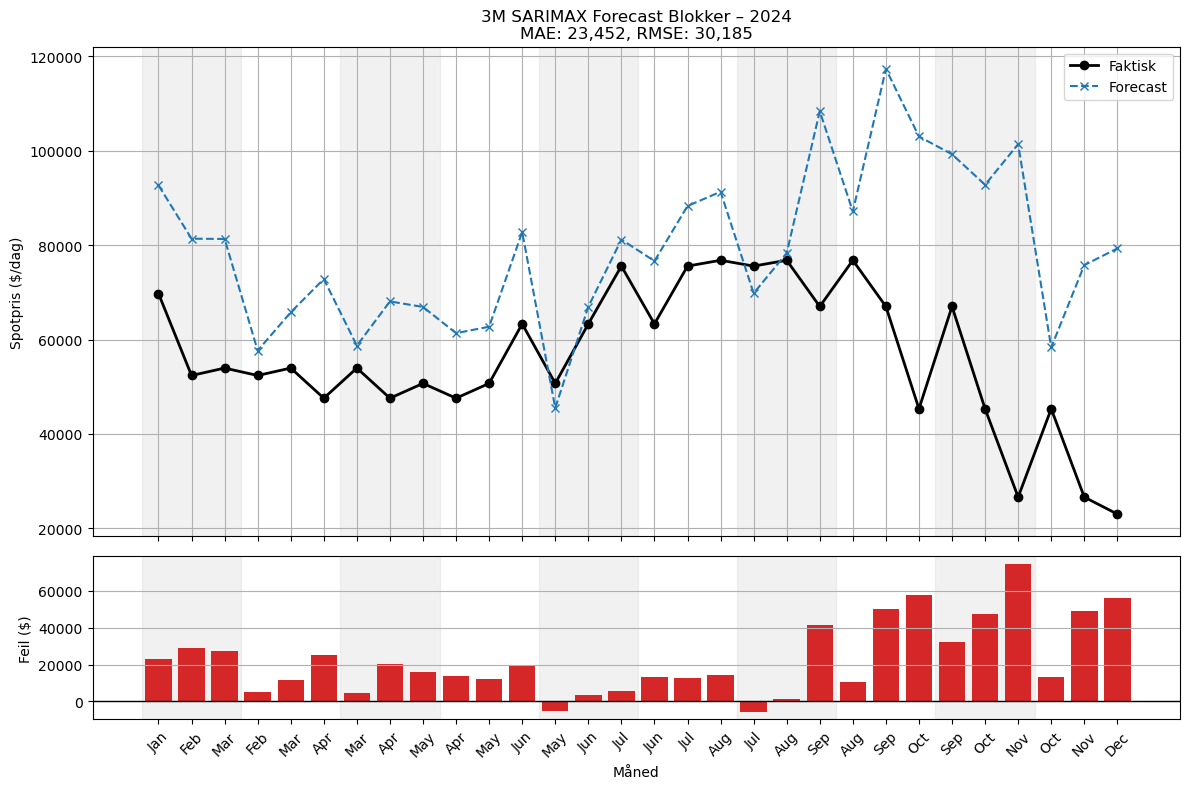

,MAE,RMSE
BlockStart,,
January,26434.66,26558.26
February,14117.81,16385.26
March,13822.22,15339.70
April,15087.48,15418.13
May,4826.77,4901.92
June,13525.84,13546.18
July,16226.20,24141.28
August,39467.14,44621.15
September,51522.64,54446.56


In [23]:
# === 1. Forecast configuration ===
forecast_start_dates = pd.date_range(start="2024-01-01", end="2024-10-01", freq="MS")

forecasts_3m = []
actuals_3m = []
forecast_months_3m = []
block_start_months = []  # brukes til korrekt gruppering

# === 2. Rolling 3M SARIMAX forecast with log-transform ===
for start_date in forecast_start_dates:
    train_end = start_date - pd.DateOffset(months=1)
    train_df = df[:train_end]
    forecast_period = pd.date_range(start=start_date, periods=3, freq="MS")

    if not set(forecast_period).issubset(df.index):
        break

    actual = df.loc[forecast_period, target].dropna()
    if len(actual) < 3:
        break

    log_train_target = np.log(train_df[target].dropna())
    exog_train = train_df.loc[log_train_target.index, exog_vars]
    exog_test = df.loc[forecast_period, exog_vars]

    model = SARIMAX(
        log_train_target,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log = model.forecast(steps=3, exog=exog_test)
    forecast = np.exp(forecast_log)

    forecasts_3m.extend(forecast)
    actuals_3m.extend(actual.values)
    forecast_months_3m.extend(forecast_period)

    # Registrer blokkmåned 3 ganger (en gang per prediksjon i blokken)
    block_start_months.extend([start_date.strftime("%B")] * 3)

# === 3. Evaluer per blokk (startmåned) ===
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_eval_3m = pd.DataFrame({
    "BlockStart": block_start_months,
    "Forecast": forecasts_3m,
    "Actual": actuals_3m
})
df_eval_3m["Abs_Error"] = abs(df_eval_3m["Forecast"] - df_eval_3m["Actual"])
df_eval_3m["Sq_Error"] = (df_eval_3m["Forecast"] - df_eval_3m["Actual"]) ** 2

monthly_block_errors = df_eval_3m.groupby("BlockStart").agg(
    MAE=("Abs_Error", "mean"),
    RMSE=("Sq_Error", lambda x: np.sqrt(np.mean(x)))
).reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October"
])

# === 4. Plot original series and residuals ===
import matplotlib.pyplot as plt

x = np.arange(1, len(forecast_months_3m) + 1)
month_labels = [d.strftime('%b') for d in forecast_months_3m]
residuals = np.array(forecasts_3m) - np.array(actuals_3m)
mae_3m = mean_absolute_error(actuals_3m, forecasts_3m)
rmse_3m = np.sqrt(mean_squared_error(actuals_3m, forecasts_3m))

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axes[0].plot(x, actuals_3m, marker='o', label="Faktisk", color='black', linewidth=2)
axes[0].plot(x, forecasts_3m, marker='x', linestyle='--', label="Forecast", color='tab:blue')

# Skygge 3M blokker
block_len = 3
block_count = len(x) // block_len
for i in range(block_count):
    if i % 2 == 0:
        axes[0].axvspan(i * block_len + 0.5, (i + 1) * block_len + 0.5, color='lightgray', alpha=0.3)
        axes[1].axvspan(i * block_len + 0.5, (i + 1) * block_len + 0.5, color='lightgray', alpha=0.3)

axes[0].set_title(f"3M SARIMAX Forecast Blokker – 2024\nMAE: {int(mae_3m):,}, RMSE: {int(rmse_3m):,}")
axes[0].set_ylabel("Spotpris ($/dag)")
axes[0].legend()
axes[0].grid(True)

axes[1].bar(x, residuals, color='tab:red')
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_ylabel("Feil ($)")
axes[1].set_xlabel("Måned")
axes[1].grid(True, axis='y')
axes[1].set_xticks(x)
axes[1].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()

# === 5. Vis blokkbaserte feil per måned ===
monthly_block_errors_rounded = monthly_block_errors.round(2)
display(monthly_block_errors_rounded)


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wi

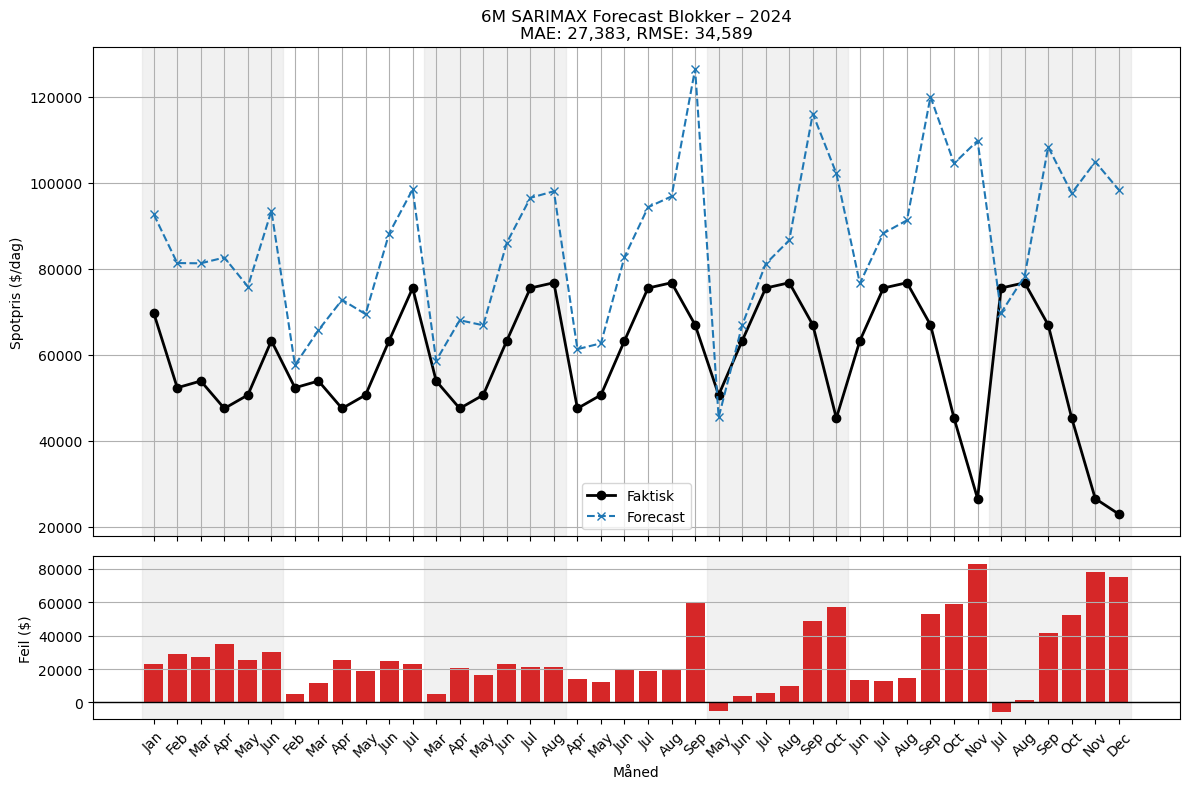

,MAE,RMSE
BlockStart,,
January,28301.61,28563.86
February,18171.49,19608.20
March,17750.05,18786.61
April,23938.14,28895.78
May,21730.76,31146.13
June,39347.75,47957.37
July,42447.48,52123.22


In [19]:
# === 1. Forecast configuration ===
forecast_start_dates = pd.date_range(start="2024-01-01", end="2024-07-01", freq="MS")  # siste startdato = juli

forecasts_6m = []
actuals_6m = []
forecast_months_6m = []
block_start_months_6m = []

# === 2. Rolling 6M SARIMAX forecast with log-transform ===
for start_date in forecast_start_dates:
    train_end = start_date - pd.DateOffset(months=1)
    train_df = df[:train_end]
    forecast_period = pd.date_range(start=start_date, periods=6, freq="MS")

    if not set(forecast_period).issubset(df.index):
        break

    actual = df.loc[forecast_period, target].dropna()
    if len(actual) < 6:
        break

    log_train_target = np.log(train_df[target].dropna())
    exog_train = train_df.loc[log_train_target.index, exog_vars]
    exog_test = df.loc[forecast_period, exog_vars]

    model = SARIMAX(
        log_train_target,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log = model.forecast(steps=6, exog=exog_test)
    forecast = np.exp(forecast_log)

    forecasts_6m.extend(forecast)
    actuals_6m.extend(actual.values)
    forecast_months_6m.extend(forecast_period)
    block_start_months_6m.extend([start_date.strftime("%B")] * 6)

# === 3. Evaluer per blokk (startmåned) ===
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_eval_6m = pd.DataFrame({
    "BlockStart": block_start_months_6m,
    "Forecast": forecasts_6m,
    "Actual": actuals_6m
})
df_eval_6m["Abs_Error"] = abs(df_eval_6m["Forecast"] - df_eval_6m["Actual"])
df_eval_6m["Sq_Error"] = (df_eval_6m["Forecast"] - df_eval_6m["Actual"]) ** 2

monthly_block_errors_6m = df_eval_6m.groupby("BlockStart").agg(
    MAE=("Abs_Error", "mean"),
    RMSE=("Sq_Error", lambda x: np.sqrt(np.mean(x)))
).reindex([
    "January", "February", "March", "April", "May", "June", "July"
])

# === 4. Plot original series and residuals ===
import matplotlib.pyplot as plt

x = np.arange(1, len(forecast_months_6m) + 1)
month_labels = [d.strftime('%b') for d in forecast_months_6m]
residuals = np.array(forecasts_6m) - np.array(actuals_6m)
mae_6m = mean_absolute_error(actuals_6m, forecasts_6m)
rmse_6m = np.sqrt(mean_squared_error(actuals_6m, forecasts_6m))

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

axes[0].plot(x, actuals_6m, marker='o', label="Faktisk", color='black', linewidth=2)
axes[0].plot(x, forecasts_6m, marker='x', linestyle='--', label="Forecast", color='tab:blue')

block_len = 6
block_count = len(x) // block_len
for i in range(block_count):
    if i % 2 == 0:
        axes[0].axvspan(i * block_len + 0.5, (i + 1) * block_len + 0.5, color='lightgray', alpha=0.3)
        axes[1].axvspan(i * block_len + 0.5, (i + 1) * block_len + 0.5, color='lightgray', alpha=0.3)

axes[0].set_title(f"6M SARIMAX Forecast Blokker – 2024\nMAE: {int(mae_6m):,}, RMSE: {int(rmse_6m):,}")
axes[0].set_ylabel("Spotpris ($/dag)")
axes[0].legend()
axes[0].grid(True)

axes[1].bar(x, residuals, color='tab:red')
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_ylabel("Feil ($)")
axes[1].set_xlabel("Måned")
axes[1].grid(True, axis='y')
axes[1].set_xticks(x)
axes[1].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()

# === 5. Vis blokkbaserte feil per måned ===
monthly_block_errors_6m_rounded = monthly_block_errors_6m.round(2)
display(monthly_block_errors_6m_rounded)


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


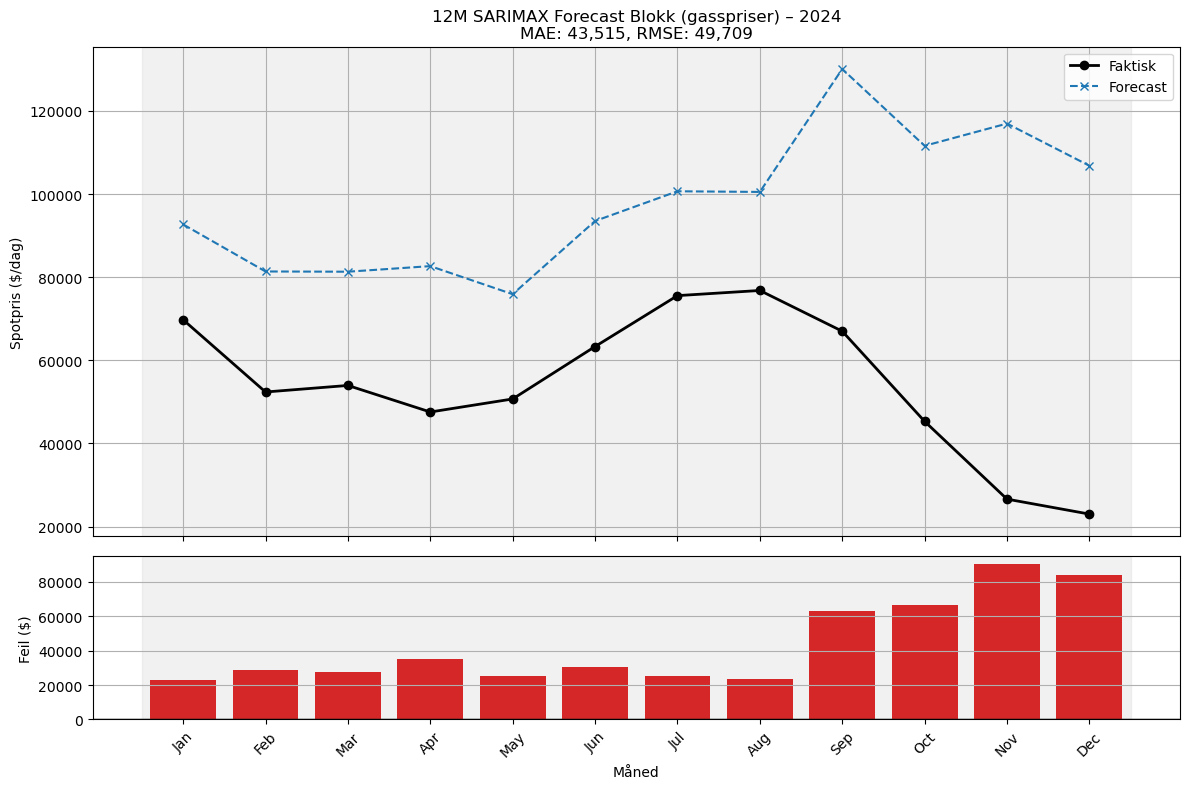

In [25]:
# === 1. Sett opp 12M forecastperiode ===
start_date_12m = pd.to_datetime("2024-01-01")
forecast_period_12m = pd.date_range(start=start_date_12m, periods=12, freq="MS")

train_end_12m = start_date_12m - pd.DateOffset(months=1)
train_df_12m = df[:train_end_12m]
actual_12m = df.loc[forecast_period_12m, target].dropna()

# === 2. Kjør SARIMAX 12M forecast hvis faktisk data er tilgjengelig ===
if len(actual_12m) == 12:
    log_train_target = np.log(train_df_12m[target].dropna())
    exog_train = train_df_12m.loc[log_train_target.index, exog_vars]
    exog_test = df.loc[forecast_period_12m, exog_vars]

    model_12m = SARIMAX(
        log_train_target,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log_12m = model_12m.forecast(steps=12, exog=exog_test)
    forecast_12m = np.exp(forecast_log_12m)

    # === 3. Evaluer og visualiser 12M forecast ===
    residuals_12m = forecast_12m - actual_12m.values
    mae_12m = mean_absolute_error(actual_12m.values, forecast_12m)
    rmse_12m = np.sqrt(mean_squared_error(actual_12m.values, forecast_12m))
    x = np.arange(1, 13)
    month_labels = [d.strftime('%b') for d in forecast_period_12m]

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    axes[0].plot(x, actual_12m.values, marker='o', label="Faktisk", color='black', linewidth=2)
    axes[0].plot(x, forecast_12m, marker='x', linestyle='--', label="Forecast", color='tab:blue')
    axes[0].axvspan(0.5, 12.5, color='lightgray', alpha=0.3)
    axes[1].axvspan(0.5, 12.5, color='lightgray', alpha=0.3)

    axes[0].set_title(f"12M SARIMAX Forecast Blokk (gasspriser) – 2024\nMAE: {int(mae_12m):,}, RMSE: {int(rmse_12m):,}")
    axes[0].set_ylabel("Spotpris ($/dag)")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].bar(x, residuals_12m, color='tab:red')
    axes[1].axhline(0, color='black', linewidth=1)
    axes[1].set_ylabel("Feil ($)")
    axes[1].set_xlabel("Måned")
    axes[1].grid(True, axis='y')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(month_labels, rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("Ikke nok faktisk data tilgjengelig for hele 2024.")


C:\Users\Eier\AppData\Local\Temp\ipykernel_29508\2236353634.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\s


SARIMAX 12M coefficients:
                          Coef.      Std.Err.             z     P>|z|  \
JKM              -2.632166e+07  2.767854e-02 -9.509773e+08  0.000000   
TTF               1.464199e+07  2.498280e-02  5.860826e+08  0.000000   
NBP               1.167967e+07  5.311093e-02  2.199109e+08  0.000000   
Spread EU-US      1.525142e+07  2.848948e-02  5.353351e+08  0.000000   
Spread ASIA-US   -3.571746e+06  2.635875e-02 -1.355051e+08  0.000000   
Spread ASIA-EU    2.989341e+07  7.528757e-03  3.970563e+09  0.000000   
Active_LNG_Fleet -1.994449e-08  8.468010e-08 -2.355275e-01  0.813799   
ar.L1             6.505824e-01  5.586817e-01  1.164496e+00  0.244223   
ma.L1            -4.875108e-01  5.897452e-01 -8.266465e-01  0.408437   
ma.L2            -2.844980e-01  1.929324e-01 -1.474599e+00  0.140320   
ar.S.L12          2.751520e-01  2.694455e-01  1.021179e+00  0.307170   
sigma2            8.940566e-02  2.569593e-02  3.479371e+00  0.000503   

                      CI_lower     

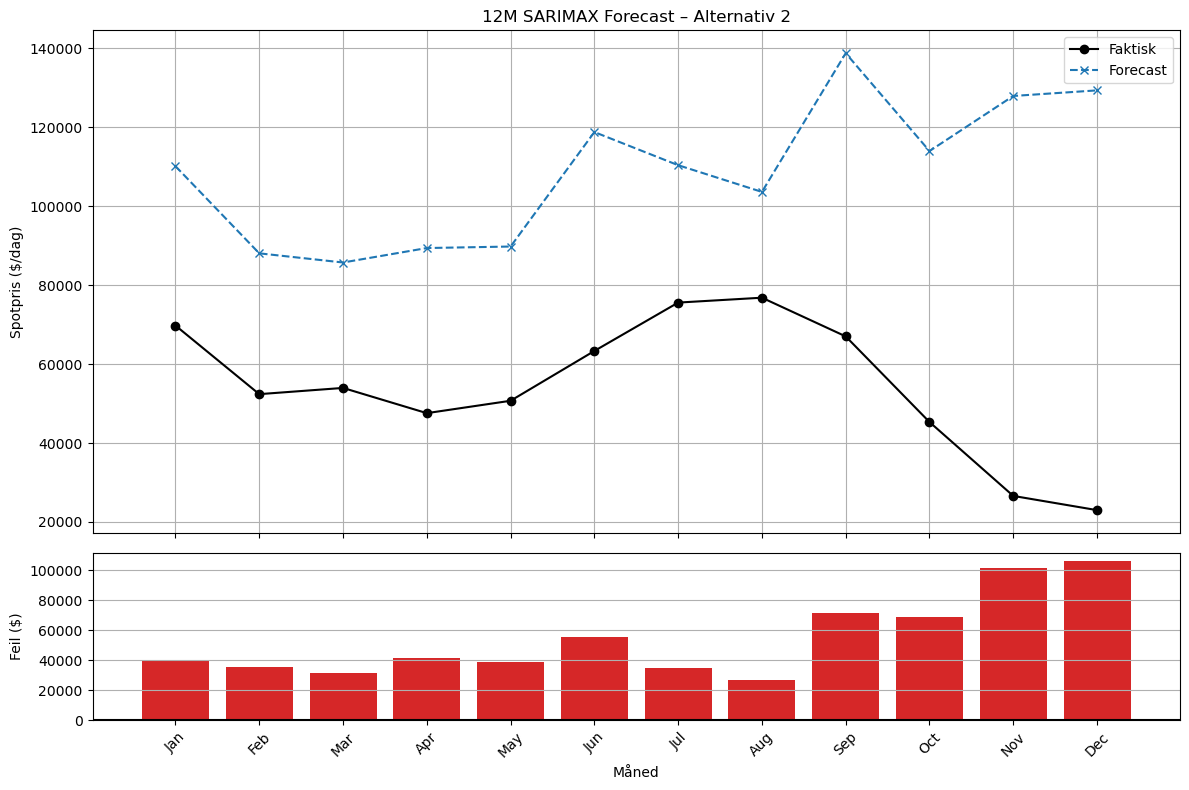

In [45]:
# === SARIMAX forecast: Alternativ 2 (Gasspriser + Flåtekapasitet) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 1. Last inn og klargjør data ===
df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
df.set_index("Date", inplace=True)

# Rens kolonnenavn og gi nye navn
df.columns = df.columns.str.replace('\n', ' ', regex=True).str.strip()
df.rename(columns={
    'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 'Spot_Rate',
    'Global price of Natural Gas, Asia (start month, MMBTU)': 'JKM',
    'Global price of Natural Gas, EU (start month, MMBTU)': 'TTF',
    'Global price of Natural Gas, US Henry Hub (start month, MMBTU)': 'NBP',
    'LNG Shipping Capacity (CBM)': 'Active_LNG_Fleet'
}, inplace=True)

# === 3. Modellparametere og forklaringsvariabler ===
target = "Spot_Rate"
exog_vars = ["JKM", "TTF", "NBP", "Spread EU-US", "Spread ASIA-US", "Spread ASIA-EU", "Active_LNG_Fleet"]
order = (1, 1, 2)
seasonal_order = (1, 0, 0, 12)

# === 4. Forecast-funksjon med blokksporing ===
def rolling_sarimax_forecast(df, target, exog_vars, start_date, horizon_months):
    forecast_dates = pd.date_range(start=start_date, end="2024-12-01", freq="MS")
    forecast_dates = forecast_dates[:-(horizon_months-1)] if horizon_months > 1 else forecast_dates

    forecasts, actuals, forecast_months, block_labels = [], [], [], []

    for start_date in forecast_dates:
        train_end = start_date - pd.DateOffset(months=1)
        train_df = df[:train_end]
        forecast_period = pd.date_range(start=start_date, periods=horizon_months, freq="MS")

        if not set(forecast_period).issubset(df.index):
            break

        actual = df.loc[forecast_period, target].dropna()
        if len(actual) < horizon_months:
            break

        log_train = np.log(train_df[target].dropna())
        exog_train = train_df.loc[log_train.index, exog_vars]
        exog_test = df.loc[forecast_period, exog_vars]

        model = SARIMAX(
            log_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_log = model.forecast(steps=horizon_months, exog=exog_test)
        forecast = np.exp(forecast_log)

        forecasts.extend(forecast)
        actuals.extend(actual.values)
        forecast_months.extend(forecast_period)

        # Bruk startmåned som label
        block_label = start_date.strftime("%B")
        block_labels.extend([block_label] * horizon_months)

    return forecasts, actuals, forecast_months, block_labels

# === 5. Kjør 1M, 3M, 6M forecasts
results = {}
block_eval = {}

for horizon in [1, 3, 6]:
    forecasts, actuals, months, blocks = rolling_sarimax_forecast(
        df, target, exog_vars, start_date=pd.to_datetime("2024-01-01"), horizon_months=horizon
    )
    results[f"{horizon}M"] = {"forecast": forecasts, "actual": actuals, "months": months}
    
    df_eval = pd.DataFrame({
        "Forecast": forecasts,
        "Actual": actuals,
        "Block": blocks
    })
    df_eval["Abs_Error"] = abs(df_eval["Forecast"] - df_eval["Actual"])
    df_eval["Sq_Error"] = (df_eval["Forecast"] - df_eval["Actual"]) ** 2

    block_stats = df_eval.groupby("Block").agg(
        MAE=("Abs_Error", "mean"),
        RMSE=("Sq_Error", lambda x: np.sqrt(np.mean(x)))
    ).reindex([
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ])

    block_eval[f"{horizon}M"] = block_stats.round(2)

# === 6. Kjør 12M forecast separat
forecast_period_12m = pd.date_range(start="2024-01-01", periods=12, freq="MS")
train_df_12m = df[:'2023-12-01']
actual_12m = df.loc[forecast_period_12m, "Spot_Rate"].dropna()

if len(actual_12m) == 12:
    log_train = np.log(train_df_12m["Spot_Rate"].dropna())
    exog_train = train_df_12m.loc[log_train.index, exog_vars]
    exog_test = df.loc[forecast_period_12m, exog_vars]

    model_12m = SARIMAX(
        log_train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log_12m = model_12m.forecast(steps=12, exog=exog_test)
    forecast_12m = np.exp(forecast_log_12m)

    results["12M"] = {
        "forecast": forecast_12m,
        "actual": actual_12m.values,
        "months": forecast_period_12m
    }

# Get parameter estimates, standard errors, z, p-values, confidence intervals
params = model_12m.params
bse = model_12m.bse
z = params / bse
pvalues = model_12m.pvalues
conf_int = model_12m.conf_int()

# Combine into a DataFrame for easy export
coefs_df = pd.DataFrame({
    "Coef.": params,
    "Std.Err.": bse,
    "z": z,
    "P>|z|": pvalues,
    "CI_lower": conf_int[0],
    "CI_upper": conf_int[1]
})

print("\nSARIMAX 12M coefficients:\n", coefs_df)


# === 7. Print samlet ytelse
evaluation = []
for key, res in results.items():
    mae = mean_absolute_error(res["actual"], res["forecast"])
    rmse = np.sqrt(mean_squared_error(res["actual"], res["forecast"]))
    evaluation.append({
        "Horizon": key,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2)
    })

eval_df = pd.DataFrame(evaluation).sort_values("Horizon")
print("\n📊 SARIMAX Forecast Evaluation – Alternativ 2 (Gass + Flåtekapasitet):")
print(eval_df)

# === 8. Valgfritt: Plott én forecast og vis blokk-MAE/RMSE ===
selected = "12M"  # eller "1M", "6M", "12M"
res = results[selected]

x = np.arange(1, len(res["months"]) + 1)
month_labels = [d.strftime('%b') for d in res["months"]]
residuals = np.array(res["forecast"]) - np.array(res["actual"])

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
axes[0].plot(x, res["actual"], marker='o', label="Faktisk", color='black')
axes[0].plot(x, res["forecast"], marker='x', linestyle='--', label="Forecast", color='tab:blue')
axes[0].set_title(f"{selected} SARIMAX Forecast – Alternativ 2")
axes[0].set_ylabel("Spotpris ($/dag)")
axes[0].legend()
axes[0].grid(True)

axes[1].bar(x, residuals, color='tab:red')
axes[1].axhline(0, color='black')
axes[1].set_ylabel("Feil ($)")
axes[1].set_xlabel("Måned")
axes[1].grid(True, axis='y')
axes[1].set_xticks(x)
axes[1].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()

# === 9. Vis blokkbasert evaluering for valgt horizon ===
if selected in block_eval:
    print(f"\n📅 Blokkvise MAE/RMSE – {selected}")
    display(block_eval[selected])


C:\Users\Eier\AppData\Local\Temp\ipykernel_29508\614194167.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\st


📊 SARIMAX Forecast Evaluation – Alternativ 3 (Full modell):
  Horizon       MAE       RMSE
3     12M  95175.59  108761.33
0      1M  13676.46   18611.90
1      3M  21888.84   28709.91
2      6M  26565.31   34006.22


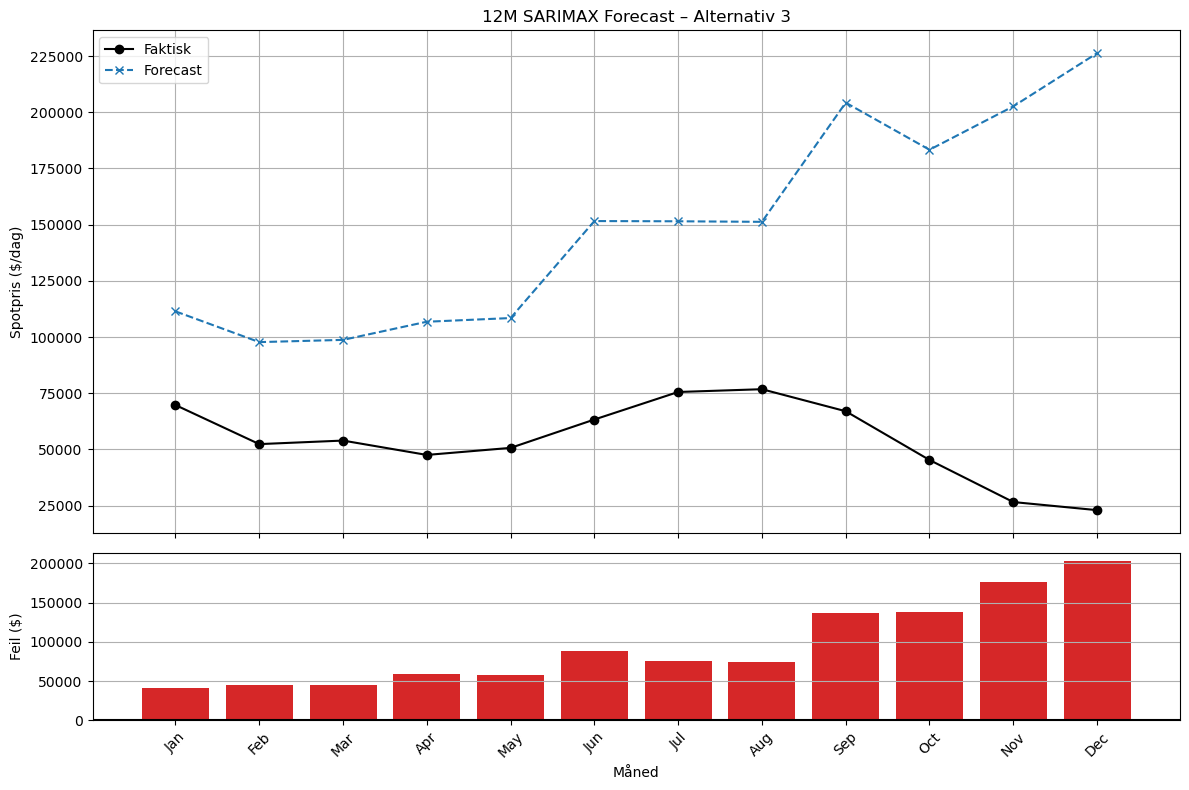

In [41]:
# === SARIMAX forecast: Alternativ 3 (Gass + Flåte + Orderbok + Nybygg) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 1. Load and prepare data ===
df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
df.set_index("Date", inplace=True)
df.columns = df.columns.str.replace('\n', ' ', regex=True).str.strip()
df.rename(columns={
    'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 'Spot_Rate',
    'Global price of Natural Gas, Asia (start month, MMBTU)': 'JKM',
    'Global price of Natural Gas, EU (start month, MMBTU)': 'TTF',
    'Global price of Natural Gas, US Henry Hub (start month, MMBTU)': 'NBP',
    'LNG Shipping Capacity (CBM)': 'Active_LNG_Fleet',
    'LNG Orderbook (start month, CBM)': 'Orderbook',
    'LNG Carrier Newbuilding Prices (end month, $m)': 'Newbuilding_Price'
}, inplace=True)

# === 3. Konfigurasjon
target = "Spot_Rate"
exog_vars = ["JKM", "TTF", "NBP", "Spread EU-US", "Spread ASIA-US", "Spread ASIA-EU",
             "Active_LNG_Fleet", "Orderbook", "Newbuilding_Price"]
order = (1, 1, 2)
seasonal_order = (1, 0, 0, 12)

# === 4. Rolling forecast-funksjon med blokketikett
def rolling_sarimax_forecast(df, target, exog_vars, start_date, horizon_months):
    forecast_dates = pd.date_range(start=start_date, end="2024-12-01", freq="MS")
    forecast_dates = forecast_dates[:-(horizon_months-1)] if horizon_months > 1 else forecast_dates

    forecasts, actuals, forecast_months, block_labels = [], [], [], []

    for start_date in forecast_dates:
        train_end = start_date - pd.DateOffset(months=1)
        train_df = df[:train_end]
        forecast_period = pd.date_range(start=start_date, periods=horizon_months, freq="MS")

        if not set(forecast_period).issubset(df.index):
            break

        actual = df.loc[forecast_period, target].dropna()
        if len(actual) < horizon_months:
            break

        log_train = np.log(train_df[target].dropna())
        exog_train = train_df.loc[log_train.index, exog_vars]
        exog_test = df.loc[forecast_period, exog_vars]

        model = SARIMAX(
            log_train,
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_log = model.forecast(steps=horizon_months, exog=exog_test)
        forecast = np.exp(forecast_log)

        forecasts.extend(forecast)
        actuals.extend(actual.values)
        forecast_months.extend(forecast_period)
        block_labels.extend([start_date.strftime("%B")] * horizon_months)

    return forecasts, actuals, forecast_months, block_labels

# === 5. Kjør forecasts for 1M, 3M, 6M
results = {}
block_eval = {}

for horizon in [1, 3, 6]:
    forecasts, actuals, months, blocks = rolling_sarimax_forecast(
        df, target=target, exog_vars=exog_vars,
        start_date=pd.to_datetime("2024-01-01"),
        horizon_months=horizon
    )
    results[f"{horizon}M"] = {"forecast": forecasts, "actual": actuals, "months": months}

    df_eval = pd.DataFrame({
        "Forecast": forecasts,
        "Actual": actuals,
        "Block": blocks
    })
    df_eval["Abs_Error"] = abs(df_eval["Forecast"] - df_eval["Actual"])
    df_eval["Sq_Error"] = (df_eval["Forecast"] - df_eval["Actual"]) ** 2

    block_stats = df_eval.groupby("Block").agg(
        MAE=("Abs_Error", "mean"),
        RMSE=("Sq_Error", lambda x: np.sqrt(np.mean(x)))
    ).reindex([
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ])

    block_eval[f"{horizon}M"] = block_stats.round(2)

# === 6. 12M statisk forecast
forecast_period_12m = pd.date_range(start="2024-01-01", periods=12, freq="MS")
train_df_12m = df[:'2023-12-01']
actual_12m = df.loc[forecast_period_12m, target].dropna()

if len(actual_12m) == 12:
    log_train = np.log(train_df_12m[target].dropna())
    exog_train = train_df_12m.loc[log_train.index, exog_vars]
    exog_test = df.loc[forecast_period_12m, exog_vars]

    model_12m = SARIMAX(
        log_train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast_log_12m = model_12m.forecast(steps=12, exog=exog_test)
    forecast_12m = np.exp(forecast_log_12m)

    results["12M"] = {
        "forecast": forecast_12m,
        "actual": actual_12m.values,
        "months": forecast_period_12m
    }

# === 7. Samlet evalueringstabell
evaluation = []
for key, res in results.items():
    mae = mean_absolute_error(res["actual"], res["forecast"])
    rmse = np.sqrt(mean_squared_error(res["actual"], res["forecast"]))
    evaluation.append({
        "Horizon": key,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2)
    })

eval_df = pd.DataFrame(evaluation).sort_values("Horizon")
print("\n📊 SARIMAX Forecast Evaluation – Alternativ 3 (Full modell):")
print(eval_df)

# === 8. Valgfritt plot og blokk-evaluering ===
selected = "12M"  # kan også være "1M", "3M", "12M"
res = results[selected]

x = np.arange(1, len(res["months"]) + 1)
month_labels = [d.strftime('%b') for d in res["months"]]
residuals = np.array(res["forecast"]) - np.array(res["actual"])

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
axes[0].plot(x, res["actual"], marker='o', label="Faktisk", color='black')
axes[0].plot(x, res["forecast"], marker='x', linestyle='--', label="Forecast", color='tab:blue')
axes[0].set_title(f"{selected} SARIMAX Forecast – Alternativ 3")
axes[0].set_ylabel("Spotpris ($/dag)")
axes[0].legend()
axes[0].grid(True)

axes[1].bar(x, residuals, color='tab:red')
axes[1].axhline(0, color='black')
axes[1].set_ylabel("Feil ($)")
axes[1].set_xlabel("Måned")
axes[1].grid(True, axis='y')
axes[1].set_xticks(x)
axes[1].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()

# === 9. Blokkbasert ytelse
if selected in block_eval:
    print(f"\n📅 Blokkvise MAE/RMSE – {selected}")
    display(block_eval[selected])


In [51]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- 1. Define your exogenous variable sets ---
exog_alt1 = ["JKM", "TTF", "NBP", "Spread EU-US", "Spread ASIA-US", "Spread ASIA-EU"]
exog_alt2 = exog_alt1 + ["Active_LNG_Fleet"]
exog_alt3 = exog_alt2 + ["LNG Orderbook (start month, CBM)", "LNG Carrier Newbuilding Prices (end month, $m)"]  # Edit as per your full model

alts = {
    "Gas": exog_alt1,
    "Gas+Fleet": exog_alt2,
    "Full": exog_alt3,
}

order = (1, 1, 2)
seasonal_order = (1, 0, 0, 12)

train_df = df[:'2023-12-01']

for name, exog_vars in alts.items():
    print(f"\n--- SARIMAX {name} ---")
    # Prepare target and exog
    log_train = np.log(train_df["Spot_Rate"].dropna())
    exog_train = train_df.loc[log_train.index, exog_vars]

    model = SARIMAX(
        log_train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Extract coefficient summary
    params = model.params
    bse = model.bse
    z = params / bse
    pvalues = model.pvalues
    conf_int = model.conf_int()
    coefs_df = pd.DataFrame({
        "Coef.": params,
        "Std.Err.": bse,
        "z": z,
        "P>|z|": pvalues,
        "CI_lower": conf_int[0],
        "CI_upper": conf_int[1]
    })

    print(coefs_df)
    coefs_df.to_csv(f"sarimax12m_coefficients_{name}.csv")



--- SARIMAX Gas ---


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                       Coef.  Std.Err.             z     P>|z|      CI_lower  \
JKM            -2.684392e+07  0.019288 -1.391760e+09  0.000000 -2.684392e+07   
TTF             1.473563e+07  0.015989  9.216079e+08  0.000000  1.473563e+07   
NBP             1.210829e+07  0.034743  3.485066e+08  0.000000  1.210829e+07   
Spread EU-US    1.554573e+07  0.018955  8.201525e+08  0.000000  1.554573e+07   
Spread ASIA-US -3.437440e+06  0.015957 -2.154227e+08  0.000000 -3.437440e+06   
Spread ASIA-EU  3.028136e+07  0.005085  5.954725e+09  0.000000  3.028136e+07   
ar.L1           5.404179e-01  0.226204  2.389075e+00  0.016891  9.706662e-02   
ma.L1          -3.512792e-01  0.271650 -1.293132e+00  0.195965 -8.837031e-01   
ma.L2          -5.687913e-01  0.197674 -2.877414e+00  0.004009 -9.562260e-01   
ar.S.L12        3.320044e-01  0.263165  1.261582e+00  0.207099 -1.837899e-01   
sigma2          7.317417e-02  0.018886  3.874478e+00  0.000107  3.615789e-02   

                    CI_upper  
JKM     

C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wi

                         Coef.      Std.Err.             z     P>|z|  \
JKM              -2.632166e+07  2.767854e-02 -9.509773e+08  0.000000   
TTF               1.464199e+07  2.498280e-02  5.860826e+08  0.000000   
NBP               1.167967e+07  5.311093e-02  2.199109e+08  0.000000   
Spread EU-US      1.525142e+07  2.848948e-02  5.353351e+08  0.000000   
Spread ASIA-US   -3.571746e+06  2.635875e-02 -1.355051e+08  0.000000   
Spread ASIA-EU    2.989341e+07  7.528757e-03  3.970563e+09  0.000000   
Active_LNG_Fleet -1.994449e-08  8.468010e-08 -2.355275e-01  0.813799   
ar.L1             6.505824e-01  5.586817e-01  1.164496e+00  0.244223   
ma.L1            -4.875108e-01  5.897452e-01 -8.266465e-01  0.408437   
ma.L2            -2.844980e-01  1.929324e-01 -1.474599e+00  0.140320   
ar.S.L12          2.751520e-01  2.694455e-01  1.021179e+00  0.307170   
sigma2            8.940566e-02  2.569593e-02  3.479371e+00  0.000503   

                      CI_lower      CI_upper  
JKM             

C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- 1. Load data ---
df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
df.set_index("Date", inplace=True)

# --- 2. Clean column names (remove newlines, strip spaces) ---
df.columns = [col.replace('\n', ' ').strip() for col in df.columns]
print("Cleaned columns:", df.columns)

# --- 3. Define target column ---
target = "LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)"

# --- 4. Define exogenous variable lists for each alternative ---
exog_alt1 = [
    "Global price of Natural Gas, Asia (start month, MMBTU)",
    "Global price of Natural Gas, EU (start month, MMBTU)",
    "Global price of Natural Gas, US Henry Hub (start month, MMBTU)",
    "Spread EU-US", "Spread ASIA-US", "Spread ASIA-EU"
]
exog_alt2 = exog_alt1 + ["LNG Shipping Capacity (CBM)"]
exog_alt3 = exog_alt2 + [
    "LNG Orderbook (start month, CBM)",
    "LNG Carrier Newbuilding Prices (end month, $m)"
]

alts = {
    "Gas-only": exog_alt1,
    "Gas+Fleet": exog_alt2,
    "Full Model": exog_alt3,
}

# --- 5. Prepare log-transformed target and exog up to Dec 2023 ---
log_train = np.log(df[target].dropna())
train_idx = log_train.index <= '2023-12-01'
log_train_static = log_train[train_idx]

results = {}

for name, exog_vars in alts.items():
    exog_vars_present = [col for col in exog_vars if col in df.columns]
    exog_train_static = df.loc[log_train_static.index, exog_vars_present]

    # === DEBUG PRINTS: Check shapes and columns ===
    print(f"\n{name}: exog_train_static shape = {exog_train_static.shape}")
    print("Columns:", exog_train_static.columns.tolist())
    print("Any NAs:", exog_train_static.isnull().any().any())
    print("Is empty?", exog_train_static.empty)

    if exog_train_static.empty:
        print(f"Skipping {name} due to no exogenous variables present.")
        continue

    print(f"Fitting SARIMAX for {name}...")
    model = SARIMAX(
        log_train_static,
        exog=exog_train_static,
        order=(1, 1, 2),
        seasonal_order=(1, 0, 0, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    summary_dict = {
        "Number of Observations": int(model.nobs),
        "Log Likelihood": model.llf,
        "AIC": model.aic,
        "BIC": model.bic,
        "HQIC": model.hqic if hasattr(model, "hqic") else None,
    }
    results[name] = summary_dict
    print(f"Summary stats for {name}:")
    for k, v in summary_dict.items():
        if v is not None:
            print(f"  {k}: {v:.2f}")

# --- 6. Print all as LaTeX rows for a comparison table ---
print("\nLaTeX Table for all SARIMAX variants:\n")
rows = ["Statistic & Gas-only & Gas+Fleet & Full Model \\\\ \\midrule"]
for stat in ["Number of Observations", "Log Likelihood", "AIC", "BIC", "HQIC"]:
    row = stat
    for alt in ["Gas-only", "Gas+Fleet", "Full Model"]:
        val = results[alt][stat] if alt in results and stat in results[alt] and results[alt][stat] is not None else ""
        row += f" & {val:.2f}" if isinstance(val, float) or isinstance(val, int) else " & "
    row += " \\\\"
    rows.append(row)
print("\n".join(rows))


C:\Users\Eier\AppData\Local\Temp\ipykernel_29508\329807002.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("cleandata.csv", parse_dates=["Date"], dayfirst=True)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cleaned columns: Index(['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
       'LNG Shipping Capacity (CBM)',
       'LNG Carrier Newbuilding Prices (end month, $m)',
       'LNG Orderbook (start month, CBM)',
       'Global price of Natural Gas, Asia (start month, MMBTU)',
       'Global price of Natural Gas, EU (start month, MMBTU)',
       'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
       'Spread EU-US', 'Spread ASIA-US', 'Spread ASIA-EU'],
      dtype='object')

Gas-only: exog_train_static shape = (60, 6)
Columns: ['Global price of Natural Gas, Asia (start month, MMBTU)', 'Global price of Natural Gas, EU (start month, MMBTU)', 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)', 'Spread EU-US', 'Spread ASIA-US', 'Spread ASIA-EU']
Any NAs: False
Is empty? False
Fitting SARIMAX for Gas-only...
Summary stats for Gas-only:
  Number of Observations: 60.00
  Log Likelihood: -6.05
  AIC: 34.11
  BIC: 54.22
  HQIC: 41.64

Gas+Fleet: exog_tra

C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wi

Summary stats for Gas+Fleet:
  Number of Observations: 60.00
  Log Likelihood: -9.95
  AIC: 43.90
  BIC: 65.85
  HQIC: 52.12

Full Model: exog_train_static shape = (60, 9)
Columns: ['Global price of Natural Gas, Asia (start month, MMBTU)', 'Global price of Natural Gas, EU (start month, MMBTU)', 'Global price of Natural Gas, US Henry Hub (start month, MMBTU)', 'Spread EU-US', 'Spread ASIA-US', 'Spread ASIA-EU', 'LNG Shipping Capacity (CBM)', 'LNG Orderbook (start month, CBM)', 'LNG Carrier Newbuilding Prices (end month, $m)']
Any NAs: False
Is empty? False
Fitting SARIMAX for Full Model...
Summary stats for Full Model:
  Number of Observations: 60.00
  Log Likelihood: -10.97
  AIC: 49.94
  BIC: 75.54
  HQIC: 59.53

LaTeX Table for all SARIMAX variants:

Statistic & Gas-only & Gas+Fleet & Full Model \\ \midrule
Number of Observations & 60.00 & 60.00 & 60.00 \\
Log Likelihood & -6.05 & -9.95 & -10.97 \\
AIC & 34.11 & 43.90 & 49.94 \\
BIC & 54.22 & 65.85 & 75.54 \\
HQIC & 41.64 & 52.12 & 5

C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
